In [37]:
# Install and load a few useful packages
# corrplot:    for making a pretty heatmap of the sample correlation matrix
# repr:        for adjusting plot dimensions in jupyter notebook
# MASS:        for multidimensional scaling
# psych:       for the `fa` and `vss` helper functions
# GPArotation: for the oblimin rotation functionality
# scatterplot3d: for viewing Swiss Roll dataset in 3d
# vegan:       for the `isomap` function

installed <- installed.packages()
if (!"corrplot" %in% installed) {install.packages("corrplot")}
if (!"MASS" %in% installed) {install.packages("MASS")}
if (!"repr" %in% installed) {install.packages("repr")}
if (!"psych" %in% installed) {install.packages("psych")}
if (!"GPArotation" %in% installed) {install.packages("GPArotation")}
if (!"scatterplot3d" %in% installed) {install.packages("scatterplot3d")}
if (!"vegan" %in% installed) {install.packages("vegan")}

library("corrplot")
library("MASS")
library("repr") 
library("psych")
library("GPArotation")
library("scatterplot3d")
library("vegan")

# seed the rng for reproducibility
set.seed(94608)

# Helpful Visualizations

We list a few visualizations that may be helpful when exploring high-dimensional datasets. Additional techniques are discussed in the accompanying [Factor Analysis in R](./Factor Analysis in R.ipynb) and [Factor Analysis Theory](./Factor Analysis Theory.ipynb) notebooks.

In [2]:
# load dataset of wine properties
d = read.table("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", sep=',')
colnames(d) = c("type",	"alcohol", "malic", "ash", "alcalinity", "magnesium", "phenols", "flavanoids", "nonflavanoids", "proanthocyanins", "color", "hue", "dilution", "proline")
d$type <- as.factor(d$type)

# standardize all numeric columns data by subtracting column means (centering) 
# and dividing by the standard deviation (scaling)
ind = sapply(d, is.numeric)
d[ind] = lapply(d[ind], scale)

# inspect the standardized dataset
head(d)

type,alcohol,malic,ash,alcalinity,magnesium,phenols,flavanoids,nonflavanoids,proanthocyanins,color,hue,dilution,proline
1,1.5143408,-0.56066822,0.2313998,-1.1663032,1.90852151,0.8067217,1.0319081,-0.6577078,1.2214385,0.2510088,0.3611585,1.8427215,1.01015939
1,0.2455968,-0.49800856,-0.8256672,-2.4838405,0.01809398,0.5670481,0.7315653,-0.8184106,-0.5431887,-0.2924962,0.4049085,1.1103172,0.96252635
1,0.1963252,0.02117152,1.1062139,-0.2679823,0.08810981,0.8067217,1.2121137,-0.4970050,2.1299594,0.2682629,0.3174085,0.7863692,1.39122370
1,1.6867914,-0.34583508,0.4865539,-0.8069748,0.92829983,2.4844372,1.4623994,-0.9791134,1.0292513,1.1827317,-0.4263410,1.1807407,2.32800680
1,0.2948684,0.22705328,1.8352256,0.4506745,1.27837900,0.8067217,0.6614853,0.2261576,0.4002753,-0.3183774,0.3611585,0.4483365,-0.03776747
1,1.4773871,-0.51591132,0.3043010,-1.2860793,0.85828399,1.5576991,1.3622851,-0.1755994,0.6623487,0.7298108,0.4049085,0.3356589,2.23274072


### Correlation Matrix
This technique allows you to quickly you visualize the pairwise correlations between each dimension in your dataset. We used it in the [Factor Analysis in R](./Factor Analysis in R.ipynb) notebook to look at the correlations between different personality dimensions.

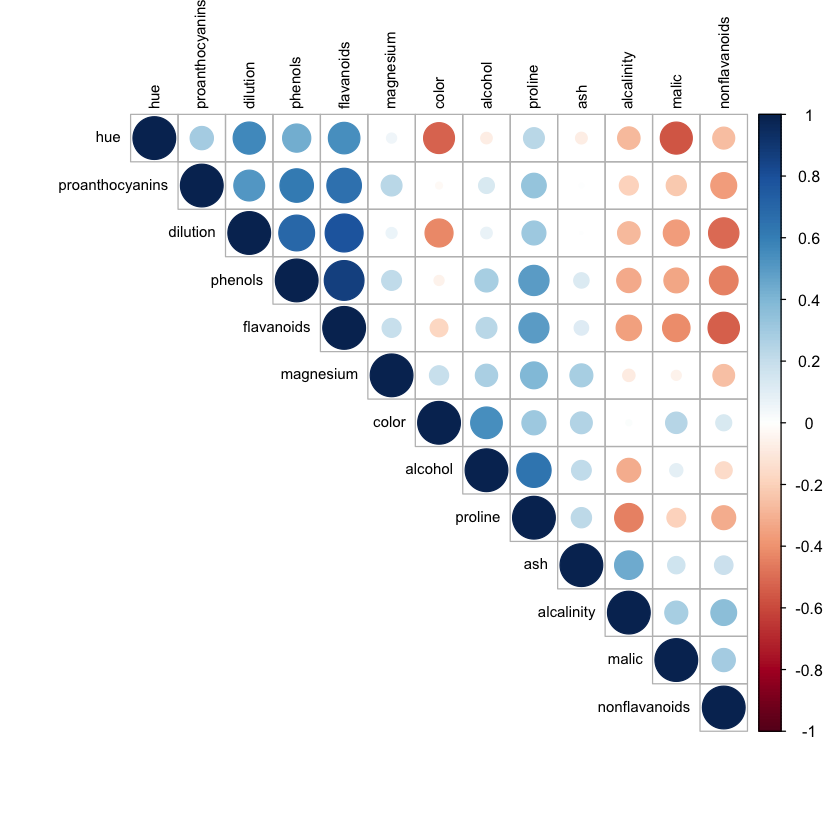

In [3]:
# look at the correlations between dimensions in the wine dataset
corrplot(cor(d[,-1]), order = "hclust", tl.col='black', tl.cex=.75, type="upper")

### Scree Plots
Scree plots are useful when trying to determine the number of components/factors/latent dimensions to use in your dimensionality reduction regimen. Here, we use a scree plot to identify the number of principal components which capture the most variance in the wine dataset. Visually, it appears that the elbow of the plot occurrs around 4 PCs.

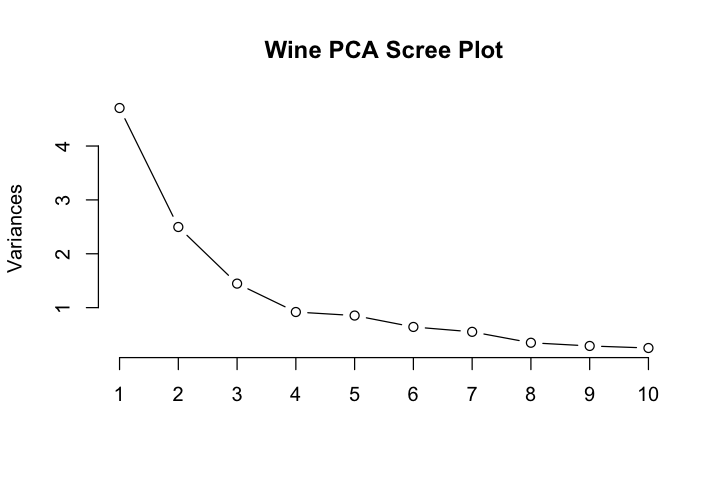

In [36]:
options(repr.plot.width=6, repr.plot.height=4)
plot(pca, type='l', main='Wine PCA Scree Plot')

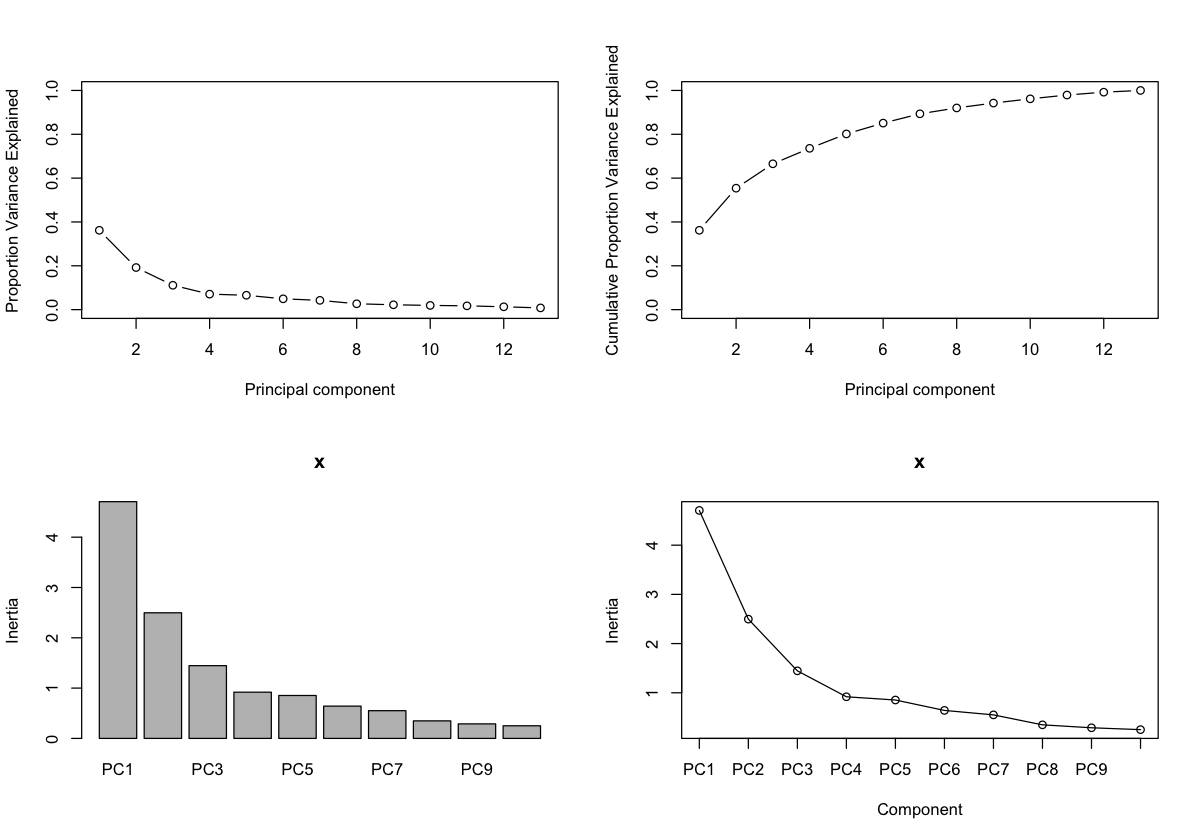

In [33]:
# here's a convenient function for displaying slightly more detailed scree plots
# credit: https://rstudio-pubs-static.s3.amazonaws.com/27823_dbc155ba66444eae9eb0a6bacb36824f.html
pcaCharts <- function(x) {
    options(repr.plot.width=10, repr.plot.height=7)
    x.var <- x$sdev ^ 2
    x.pvar <- x.var/sum(x.var)
    
    par(mfrow=c(2,2))
    plot(x.pvar,xlab="Principal component", ylab="Proportion Variance Explained", ylim=c(0,1), type='b')
    plot(cumsum(x.pvar),xlab="Principal component", ylab="Cumulative Proportion Variance Explained", ylim=c(0,1), type='b')
    screeplot(x)
    screeplot(x,type="l")
    par(mfrow=c(1,1))
}

pcaCharts(pca)

### Projections and Multidimensional Scaling
Once you've decided on the right number of dimensions/factors to look for in your data, it can often be helpful to inspect your original data in the 2- or 3-D subspace spanned by the first few PCs/factors your approach identifies. Here, we view the wine data in the space spanned by its first two principal components, and compare its result to two dimensionality reduction approaches from the psychology literature: classic and non-metric multidimensional scaling.

Multidimensional scaling (MDS) is an approach to dimensionality reduction that operates on the on pairwise dissimilarities ("distances") between dimensions. Roger Shepard famously introduced nonmetric MDS in his search for a [universal law of generalization](http://smash.psych.nyu.edu/courses/spring16/learnmem/papers/Shepard1987.pdf).

Brief descriptions:
- **Classic MDS**: Given a distance matrix, this approach finds a lower-dimensional embedding that preserves the pairwise distances as accurately as possible. In R, it is performed using the `cmdscale` function from the `MASS` package. Produces results that are very close to those of PCA. 
- **Non-metric MDS**: An iterative, non-linear method. Given a distance matrix, this approach attempts to find a lower-dimensional embedding that preserves the _relative ordering_ of the pairwise distances as closely as possible. Performed using the `isoMDS` function in the `MASS` package.

initial  value 13.531027 
iter   5 value 8.498692
iter  10 value 7.970494
iter  15 value 7.809399
iter  20 value 7.674228
iter  25 value 7.577678
final  value 7.546164 
converged


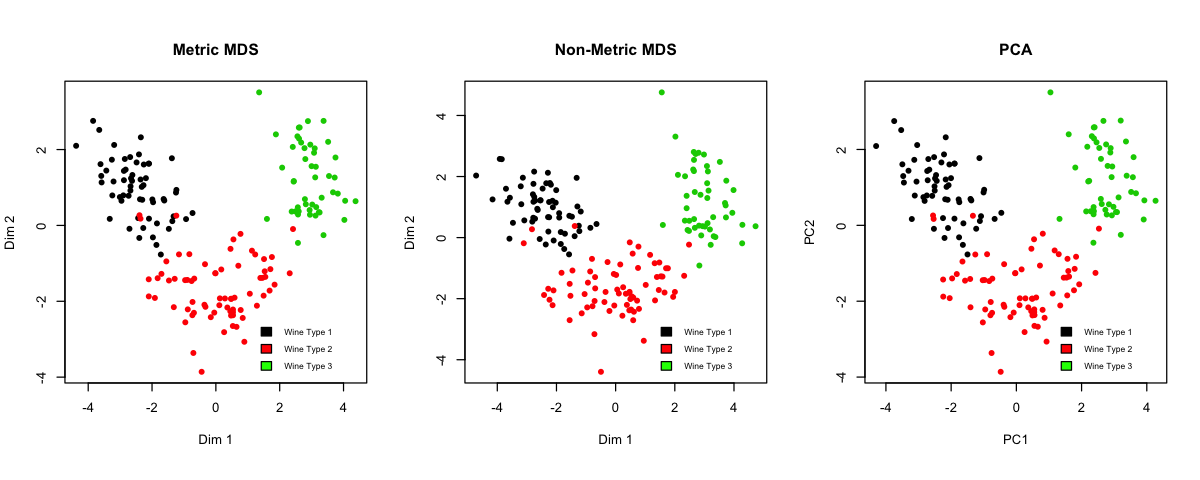

In [38]:
# adjust plotting options
options(repr.plot.width=10, repr.plot.height=4)
wine.par = par(mfrow=c(1, 3), pty="s")

# perform classic (metric) MDS with k=4 latent dimensions
mds = cmdscale(dist(d), k=4)
plot(mds[,1:2], col=d$type, pch=16, main='Metric MDS', xlab='Dim 1', ylab='Dim 2')
legend("bottomright", legend=c("Wine Type 1", "Wine Type 2", "Wine Type 3"), 
       fill=c("black", "red", "green"), bty='n', cex=0.65)

# perform non-metric MDS for k=4 latent dimensions
mds = isoMDS(dist(d), k=4)
plot(mds$points[,1:2], col=d$type, pch=16, main='Non-Metric MDS', xlab='Dim 1', ylab='Dim 2')
legend("bottomright", legend=c("Wine Type 1", "Wine Type 2", "Wine Type 3"), 
       fill=c("black", "red", "green"), bty='n', cex=0.65)

# Compare MDS against results found using top 2 principal components
pca = prcomp(d[,-1])
plot(pca$x[,1:2], col=d[,1], pch=16, main="PCA")
legend("bottomright", legend=c("Wine Type 1", "Wine Type 2", "Wine Type 3"), 
       fill=c("black", "red", "green"), bty='n', cex=0.65)

### Biplots (PCA)
`biplot` in the `stats` package can be useful when trying to interpret the output of PCA. In a biplot, the red vectors correspond to the dimensions from the original dataset, projected into the subspace spanned by the first two principal components. The length of each vector represents the strength of the correlation between the original data dimension and the principal components.

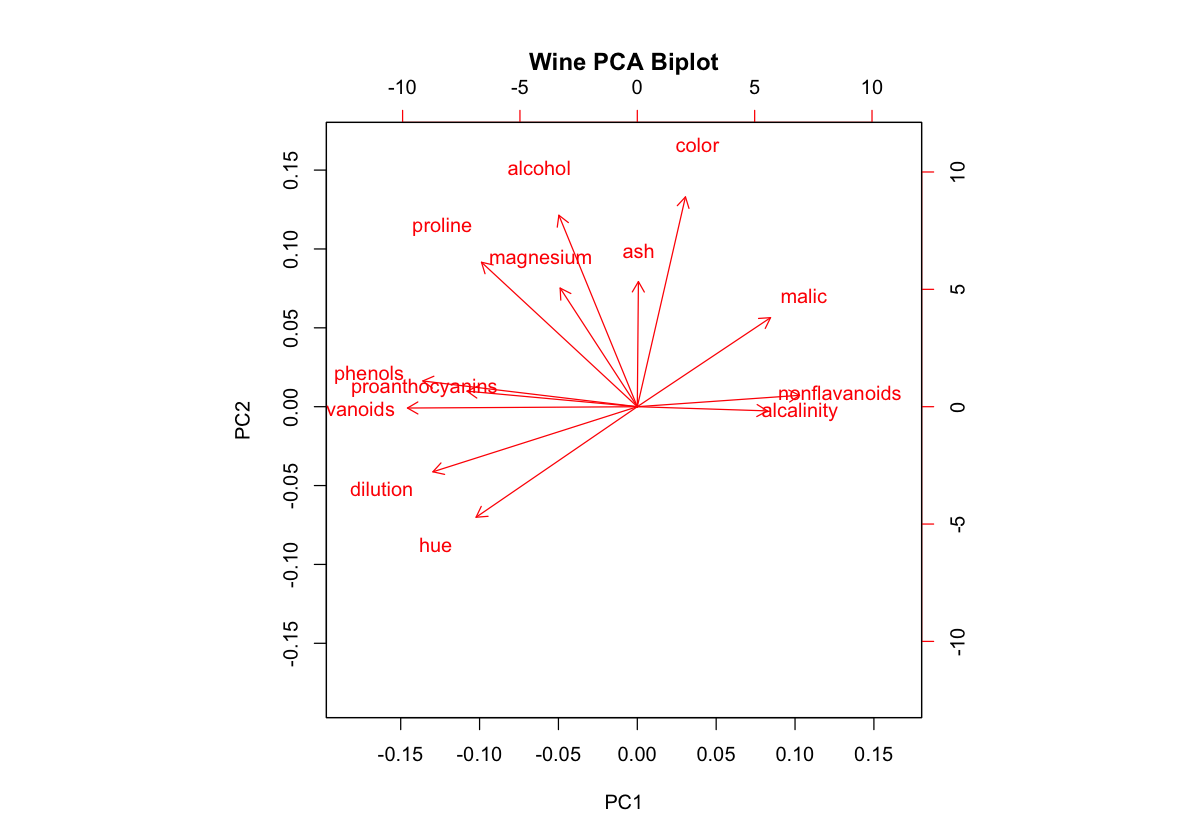

In [5]:
options(repr.plot.width=10, repr.plot.height=7)
biplot(pca, xlabs=rep("", nrow(d)), main="Wine PCA Biplot")

### Loading Plots
Loading plots are helpful for visualizing the results of a factor analysis and determining what (if any) rotation to apply. In a loading plot each dimension corresponds to a latent factor (here we only look at the first 2), and each point corresponds to the factor loadings for a given observed variable. We can compare the loading plot for our untransformed factor loadings with those achieved by using different rotations. In the current example, it seems that using an Oblimin rotation achieves the most interpretable factor loadings.

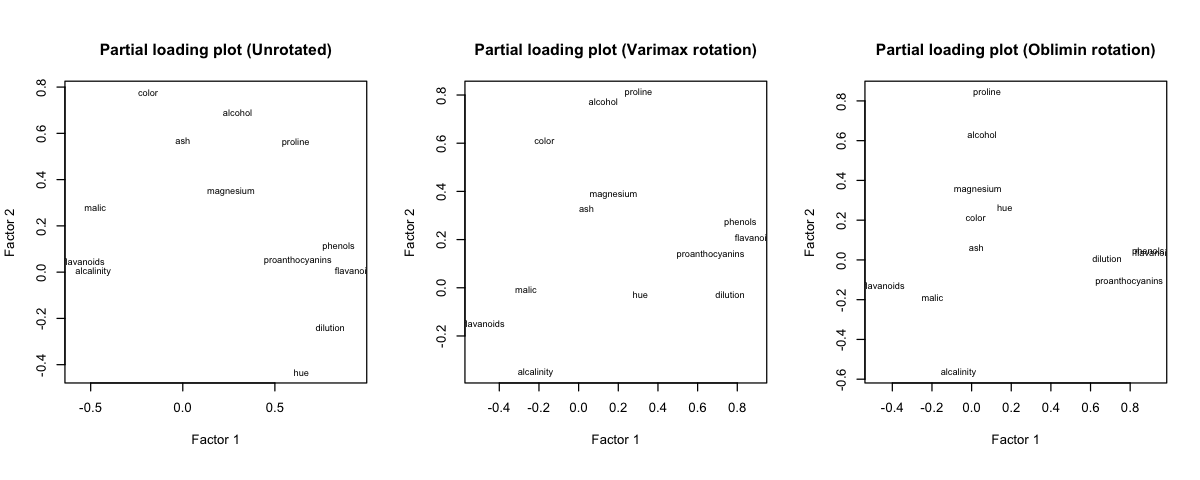

In [8]:
# here's a convenient function for quickly viewing several partial loading plots 
# under different factor rotations
faRotations <- function(x, k) {
    options(repr.plot.width=10, repr.plot.height=4)
    par(mfrow=c(1,3), pty='s')
    
    # no rotation
    res1c = fa(x, nfactors=k, rotate="none")
    load = res1c$loadings[, 1:2]
    plot(load, type="n", xlab="Factor 1", ylab="Factor 2", main="Partial loading plot (Unrotated)") 
    text(load, labels=names(x), cex=.7)

    # varimax rotation
    res1c = fa(x, nfactors=k, rotate="varimax")
    load = res1c$loadings[, 1:2]
    plot(load, type="n", xlab="Factor 1", ylab="Factor 2", main="Partial loading plot (Varimax rotation)") 
    text(load, labels=names(x), cex=.7)

    # oblimin rotation
    res1c = fa(x, nfactors=k, fm='ml', rotate="oblimin")
    load = res1c$loadings[, 1:2]
    plot(load, type="n", xlab="Factor 1", ylab="Factor 2", main="Partial loading plot (Oblimin rotation)") 
    text(load, labels=names(x), cex=.7)
}

faRotations(d[,-1], 4)

### Nonlinear Approaches
As you are well aware by now, there is no "one size fits all" approach to dimensionality reduction. Though linear approaches are often easy to understand, there are many cases in which they can be misleading. This example is meant to illustrate the importance of visualizing the fit of your dimensionality reduction technique (when possible), and introduces a classic non-linear dimensionality reduction technique known as Isomap. We'll demonstrate this using a classic synthetic dataset known as the Swiss Roll, for reasons that will become obvious upon running the cell below.

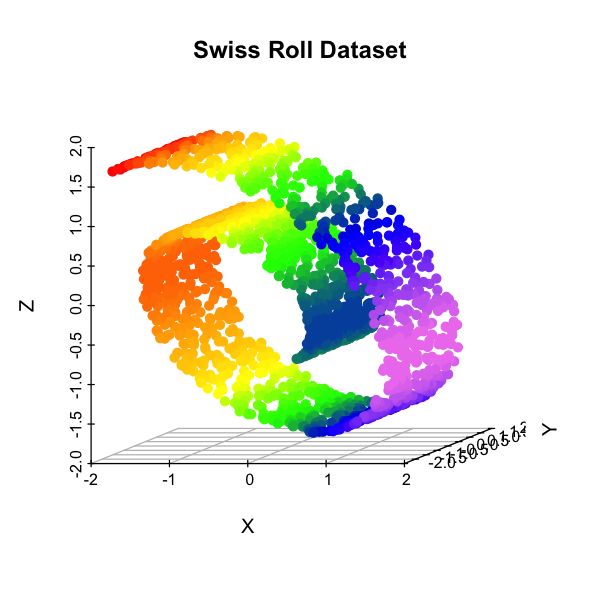

In [31]:
SwissRoll <- function(N=2000, Height=30){
    # build swiss roll manifold and assign colors
    p = (3 * pi / 2) * (1 + 2 * runif(N, 0, 1));  
    y = Height * runif(N, 0 , 1);
    samples = cbind(p * cos(p + 1), y, p * sin(p + 0.5));
    ii = cut(samples[,1], breaks=seq(min(samples[,1]), max(samples[,1]), len=100), include.lowest=TRUE)
    colors = colorRampPalette(c("red", "orange", "yellow", "green", "blue", "violet"))(99)[ii]    
    return(list("data"=samples, "colors"=colors))
}

sr = SwissRoll()
sr$data = scale(sr$data)
options(repr.plot.width=5, repr.plot.height=5)
scatterplot3d(sr$data, pch=19, scale.y=0.25, box=FALSE, color=sr$color,
              xlab='X', ylab='Y', zlab='Z', main="Swiss Roll Dataset")

Linear approaches to dimensionality reduction (like PCA) are going to fail to capture the latent structure present in the Swiss Roll dataset (or any dataset for which the points happen to lie on a nonlinear, lower-dimensional manifold). To see why, think about whether you can collapse the data points into 2D along any two (orthogonal) dimensions and still maintain the color gradient. This challenge is summarized in panel A of the figure below, where we see that any straight slice through the data will necessarily collapse different colors onto one another. 

Given this observation, the computational cognitive scientist Joshua Tenenbuam developed a well-known non-linear dimensionality reduction approach called [Isomap](http://web.mit.edu/cocosci/Papers/sci_reprint.pdf). This approach follows the nearest neighbors for each point to retrace the lower-dimensional manifold in which the data are embedded. This idea is summarized in panel B. The Isomap reduction is visualized in 2D in figure 3.

![](images/isomap.png)

The function below reproduces these analyses on the swiss roll data so that you can compare the solutions for PCA and Isomap side by side.

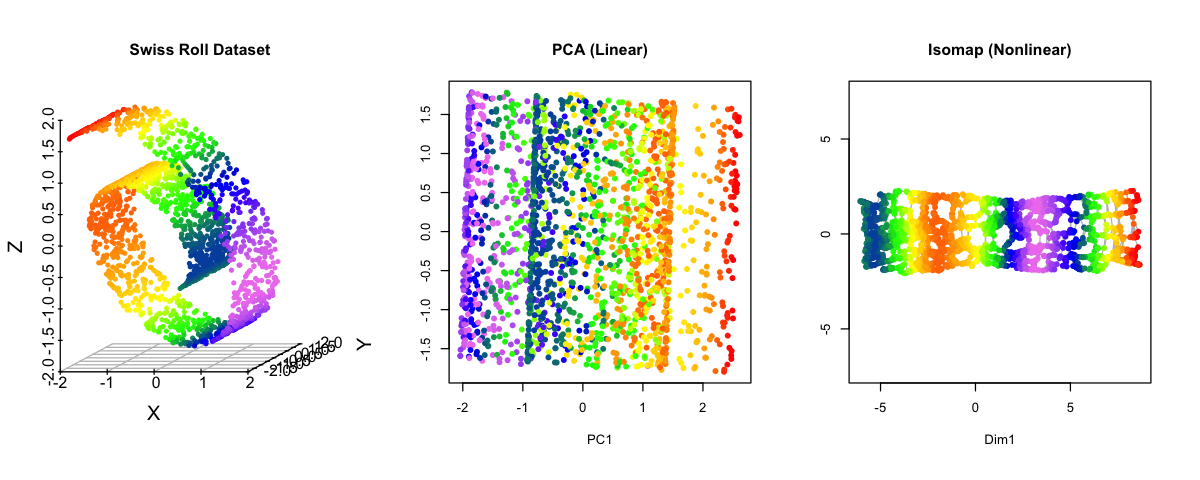

In [29]:
# here's a function for comparing the PCA and Isomap solutions
# NB. isomap can take a while to run on large inputs. Be patient!
srPlots <- function(sr) {
    options(repr.plot.width=10, repr.plot.height=4)
    par(mfrow=c(1,3), pty='s')
    
    # original data
    scatterplot3d(sr$data, pch=19, scale.y=0.25, box=FALSE, color=sr$color,
              xlab='X', ylab='Y', zlab='Z', main="Swiss Roll Dataset")
    
    # PCA result
    sr.pca = prcomp(sr$data, center=TRUE, scale=TRUE) 
    plot(sr.pca$x[,1:2], col=sr$color, pch=16, main="PCA (Linear)")
    
    # Isomap result
    sr.iso = isomap(dist(sr$data), k=5)
    plot(sr.iso, col=sr$color, pch=16, main="Isomap (Nonlinear)")
}

srPlots(sr)